# cGAN using pix2pix


## Importing the libraries

In [3]:
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
tf.__version__

'2.15.0'

## Downloading the dataset

In [4]:
dataset = 'facades'



Other datasets:
* `cityscapes`
* `edges2handbags`
* `edges2shoes`
* `facades`
* `night2day`

(https://github.com/affinelayer/pix2pix-tensorflow#datasets-and-trained-models)

In [5]:
dataset_file = "{}.tar.gz".format(dataset)
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(dataset_file)
print(dataset_url)

http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz


In [6]:
download_zip = tf.keras.utils.get_file(fname = dataset_file, origin = dataset_url, extract = True)

In [7]:
download_zip = pathlib.Path(download_zip)
path = download_zip.parent/dataset

In [8]:
path

PosixPath('/home/sohamr/.keras/datasets/facades')

In [9]:
list(path.parent.iterdir())

[PosixPath('/home/sohamr/.keras/datasets/facades.tar.gz'),
 PosixPath('/home/sohamr/.keras/datasets/mnist.npz'),
 PosixPath('/home/sohamr/.keras/datasets/facades')]

In [10]:
sample = tf.io.read_file(str(path / 'train/3.jpg'))
sample = tf.io.decode_jpeg(sample)

2024-04-03 19:29:29.331306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 19:29:29.331640: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(256, 512, 3)


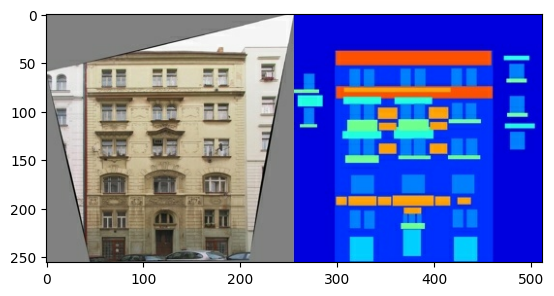

In [11]:
print(sample.shape)
plt.figure()
plt.imshow(sample);

## Functions to preprocessing

In [12]:
def load_image(img_file):
  img = tf.io.read_file(img_file)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, [256, 512])
  #print(img.shape)

  width = tf.shape(img)[1]
  #print(width)
  width = width // 2
  #print(width)
  transformed_img = img[:, :width, :]
  original_img = img[:, width:, :]

  original_img = tf.cast(original_img, tf.float32)
  transformed_img = tf.cast(transformed_img, tf.float32)

  return original_img, transformed_img

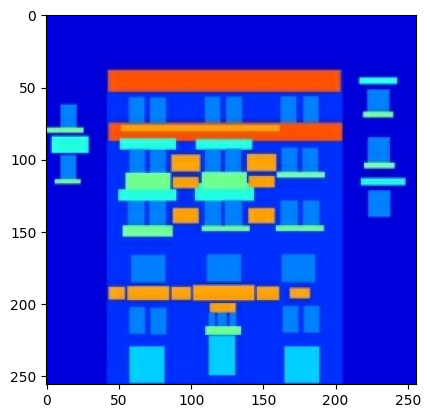

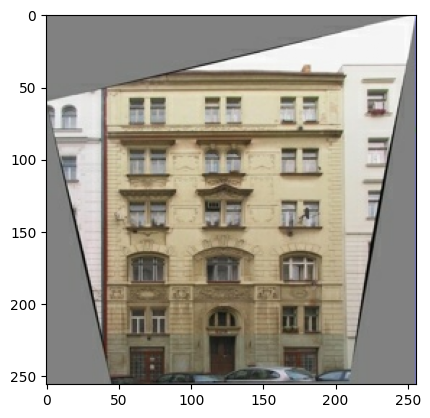

In [13]:
original_img, transformed_img = load_image(str(path / 'train/3.jpg'))
plt.figure()
plt.imshow(original_img / 255.0)
plt.figure()
plt.imshow(transformed_img / 255.0);

In [14]:
quantity_training = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
quantity_training

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [15]:
quantity_training = len(list(quantity_training))
quantity_training

400

In [16]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

In [17]:
def resize(original_img, transformed_img, width, height):
  original_img = tf.image.resize(original_img, [width, height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  transformed_img = tf.image.resize(transformed_img, [width, height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return original_img, transformed_img

In [18]:
def normalize(original_img, transformed_img):
  original_img = (original_img / 127.5) - 1
  transformed_img = (transformed_img / 127.5) - 1
  return original_img, transformed_img

In [19]:
def random_crop(original_img, transformed_img):
  stacked_img = tf.stack([original_img, transformed_img], axis = 0)
  crop_img = tf.image.random_crop(stacked_img, size = [2, img_width, img_height, 3])
  return crop_img[0], crop_img[1]

In [20]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.56575537>

In [21]:
@tf.function()
def random_jitter(original_img, transformed_img):
  original_img, transformed_img = resize(original_img, transformed_img, 286, 286)
  original_img, transformed_img = random_crop(original_img, transformed_img)
  if tf.random.uniform(()) > 0.5:
    original_img = tf.image.flip_left_right(original_img)
    transformed_img = tf.image.flip_left_right(transformed_img)
  return original_img, transformed_img

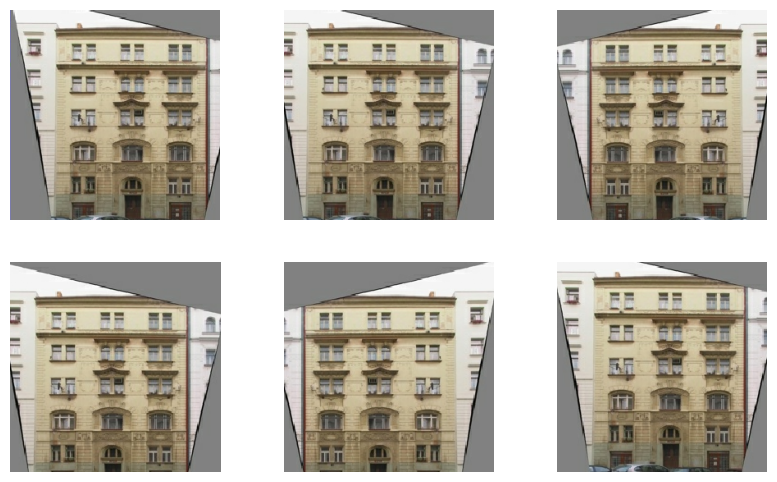

In [22]:
plt.figure(figsize = (10,6))
for i in range(6):
  j_original, j_transformed = random_jitter(original_img, transformed_img)
  plt.subplot(2,3, i + 1)
  plt.imshow(j_transformed / 255.0)
  plt.axis('off')
plt.show()

## Loading the dataset


In [23]:
def load_training_images(img_file):
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = random_jitter(original_img, transformed_img)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [24]:
def load_testing_images(img_file):
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = resize(original_img, transformed_img, img_width, img_height)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [25]:
training_dataset = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
training_dataset = training_dataset.map(load_training_images, num_parallel_calls=tf.data.AUTOTUNE)
training_dataset = training_dataset.shuffle(buffer_size)
training_dataset = training_dataset.batch(batch_size)

In [26]:
training_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [47]:
try:
  testing_dataset = tf.data.Dataset.list_files(str(path / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  testing_dataset = tf.data.Dataset.list_files(str(path / 'val/*.jpg'))
testing_dataset = testing_dataset.map(load_testing_images)
testing_dataset = testing_dataset.batch(batch_size)

## Generator

The generator is a modified version of [U-Net](https://paperswithcode.com/method/u-net).

U-Net components:
* Encoder (downsampler)
* Decoder (upsampler)

More about U-Net:
* https://paperswithcode.com/method/u-net
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

**Downsample / encode**
 * Convolution -> Batch normalization -> Leaky ReLU

In [27]:
def encode(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0, 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                    kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [32]:
original_img.shape

TensorShape([256, 256, 3])

In [28]:
down_model = encode(3, 4)
down_result = down_model(tf.expand_dims(original_img, 0))
print(down_result.shape)

(1, 128, 128, 3)


**Upsample / decode**
 * Transposed convolution -> Batch normalization -> Dropout (applyed for the first 3 blocks) -> ReLU

In [29]:
def decode(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0, 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                                             kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [30]:
up_model = decode(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [31]:
def Generator():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])

  downsampling = [
      encode(64, 4, apply_batchnorm = False), # (batch_size, 128, 128, 64)
      encode(128, 4), # (batch_size, 64, 64, 128)
      encode(256, 4), # (batch_size, 32, 32, 256)
      encode(512, 4), # (batch_size, 16, 16, 512)
      encode(512, 4), # (batch_size, 8, 8, 512)
      encode(512, 4), # (batch_size, 4, 4, 512)
      encode(512, 4), # (batch_size, 2, 2, 512)
      encode(512, 4), # (batch_size, 1, 1, 512)
  ]

  upsampling = [
      decode(512, 4, apply_dropout=True), # (batch_size, 2, 2, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 4, 4, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 8, 8, 512)
      decode(512, 4), # (batch_size, 16, 16, 512)
      decode(256, 4), # (batch_size, 32, 32, 256)
      decode(128, 4), # (batch_size, 64, 64, 128)
      decode(64, 4), # (batch_size, 128, 128, 64)
  ]

  output_channels = 3
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation='tanh') # (batch_size, 256, 256, 3)

  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(upsampling, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)


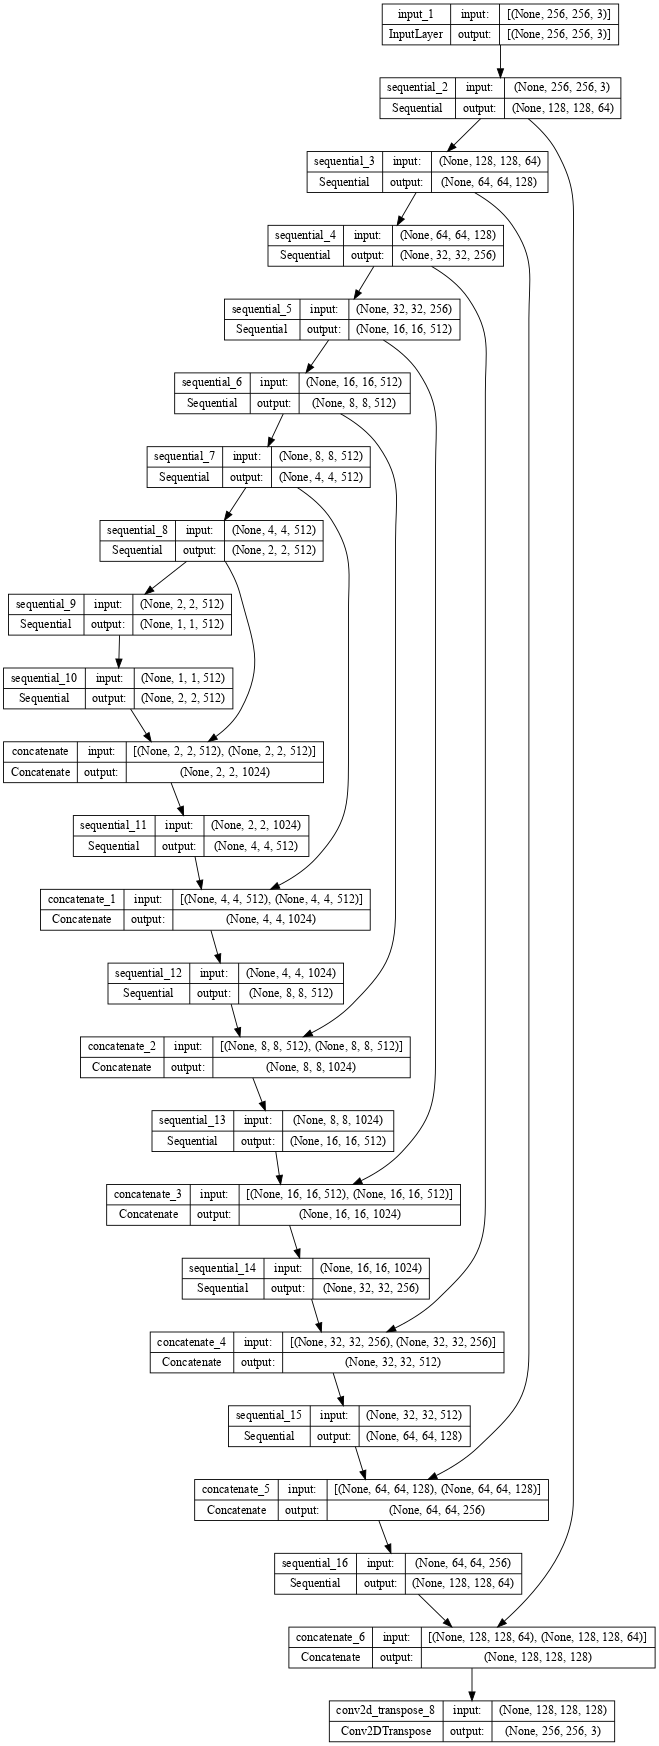

In [32]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True, dpi = 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


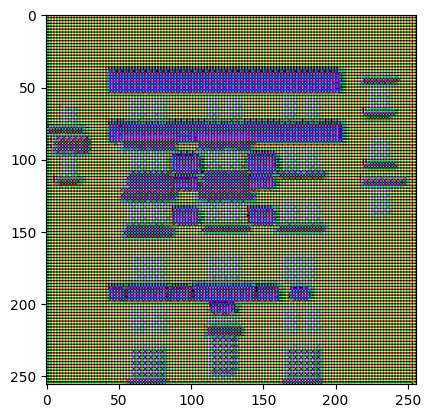

In [33]:
g_output = generator(original_img[tf.newaxis, ...], training=False)
plt.imshow(g_output[0, ...])

### Generator loss

Normal GANs learn loss that adapts to the data, while cGAN learns structured loss that penalizes a possible structure that differs from the network output and the expected "real" image. More details: https://arxiv.org/abs/1611.07004


> **Hyperparameters**

Default values suggested in the paper

* Learning rate: 0.0002
* Momentum: [β1, β2] = [0.5, 0.999]
* Lambda (λ_L1) = 100

* The generator loss is a cross-entropy sigmoid of the generated images and an array of 1's
* The pix2pix paper also mentions L1 loss, which is a MAE (Mean Absolute Error) between the generated image and the expected (real) one. This ensures that the generated image becomes structurally similar to the real image.
* The equation for calculating the total loss is gan_loss + LAMBDA * l1_loss where LAMBDA = 100 - this value is also described by the authors of the paper.

In [34]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

In [35]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [36]:
def generator_loss(d_generated_output, g_output, target):
  gan_loss = loss(tf.ones_like(d_generated_output), d_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - g_output)) # MAE
  g_loss_total = gan_loss + (lambda_ * l1_loss)
  return g_loss_total, gan_loss, l1_loss

## Discriminator

The discriminator is a [PatchGAN](https://paperswithcode.com/method/patchgan). The goal is to classify if each patch (piece) of the image is real or fake.

* Blocks of the discriminator: Convolution -> Batch normalization -> Leaky ReLU.

* The output shape is `(batch_size, 30, 30, 1)`

More information: https://arxiv.org/abs/1611.07004

The discriminator receives two inputs:
  1. The input image and the expected image, which should be classified as real
  2. The input image and the generated image (fake, generated by the generator), which should be classified as fake.

In [38]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  original = tf.keras.layers.Input(shape = [256,256,3], name='original_img')
  transformed = tf.keras.layers.Input(shape=[256,256,3], name='transformed_img')
  x = tf.keras.layers.concatenate([original, transformed]) # (batch_size, 256, 256, channels * 2)

  down1 = encode(64, 4, False)(x) # (batch_size, 128, 128, 64)
  down2 = encode(128, 4)(down1) # (batch_size, 64, 64, 128)
  down3 = encode(256, 4)(down2) # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)
  last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs = [original, transformed], outputs = last)

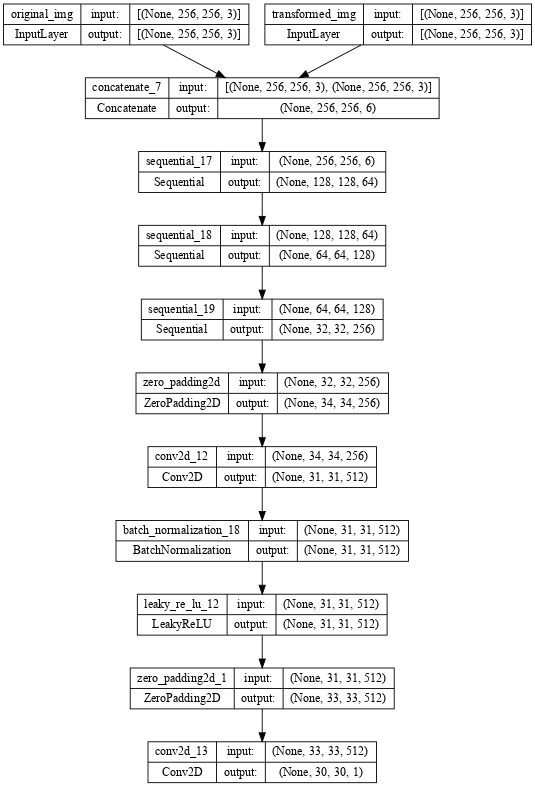

In [39]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes = True, dpi = 64)

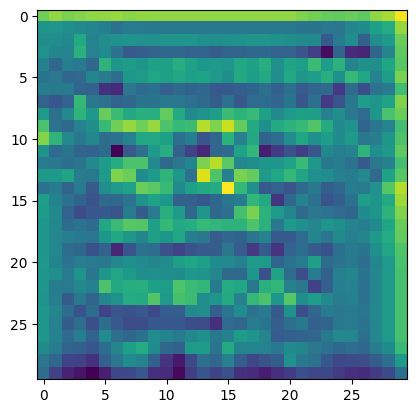

In [40]:
d_output = discriminator([original_img[tf.newaxis, ...], g_output], training=False)
plt.imshow(d_output[0, ..., -1])

### Discriminator loss

It receives two inputs: real images and generated (fake) images
* `real_loss` - sigmoid cross-entropy loss comparing the **real** image and one array of 1's
* `generated_loss (fake)` - sigmoid cross-entropy loss comparing the **generated** image and one array of 0's

The total loss is a sum of both losses

In [41]:
def discriminator_loss(d_real_output, d_generated_output):
  real_loss = loss(tf.ones_like(d_real_output), d_real_output)
  generated_loss = loss(tf.zeros_like(d_generated_output), d_generated_output)
  d_total_loss = real_loss + generated_loss
  return d_total_loss

## Optimizers

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

## Model checkpoint


In [43]:
checkpoint_dir = './models/facades'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

## Generating images

In [48]:
def generate_images(model, test_input, real, step = None):
  generated_img = model(test_input, training=True)
  plt.figure(figsize=(12,8))

  img_list = [test_input[0], real[0], generated_img[0]]
  title = ['Input image', 'Real (ground truth)', 'Generated image (fake)']

  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(title[i])
    plt.imshow(img_list[i] * 0.5 + 0.5)
    plt.axis('off')

  if step is not None:
    plt.savefig('result_pix2pix_step_{}.png'.format(step), bbox_inches='tight')

  plt.show()

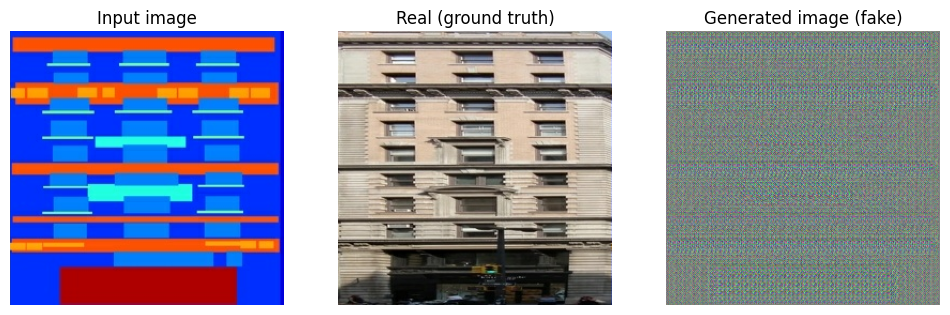

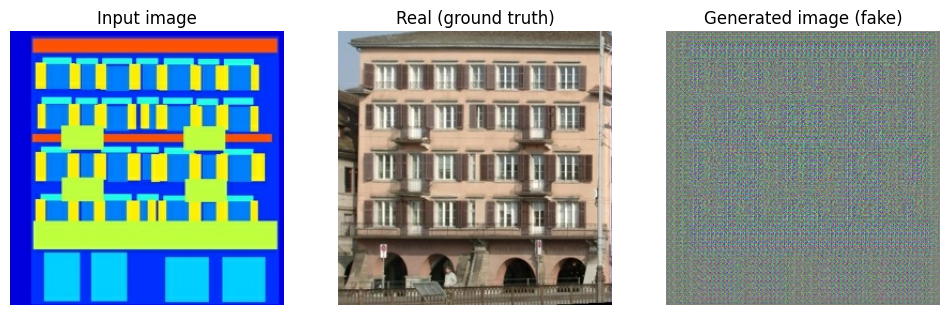

In [49]:
for input_example, real_example in testing_dataset.take(2):
  generate_images(generator, input_example, real_example)

## Training

* For each input, an output is generated.
* The discriminator receives input_img and the generated images as the first input. The second input is img_entry and the "real" (expected)
* Then, the loss of the generator and discriminator is calculated
* Then we calculate the loss gradients with respect to the generator and discriminator variables (inputs) and apply these to the optimizer.

In [50]:
@tf.function
def training_step(input_img, real, step):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_output = generator(input_img, training = True)

    d_output_real = discriminator([input_img, real], training = True)
    d_output_generated = discriminator([input_img, g_output], training = True)

    g_total_loss, g_loss_gan, g_loss_l1 = generator_loss(d_output_generated, g_output, real)
    d_loss = discriminator_loss(d_output_real, d_output_generated)

  generator_gradients = g_tape.gradient(g_total_loss, generator.trainable_variables)
  discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with metrics.as_default():
    tf.summary.scalar('g_total_loss', g_total_loss, step=step//1000)
    tf.summary.scalar('g_loss_gan', g_loss_gan, step=step//1000)
    tf.summary.scalar('g_loss_l1', g_loss_l1, step=step//1000)
    tf.summary.scalar('d_loss', d_loss, step=step//1000)

In [51]:
def train(training_dataset, testing_dataset, steps):
  test_input, real_input = next(iter(testing_dataset.take(1)))
  start = time.time()

  for step, (input_img, real_img) in training_dataset.repeat().take(steps).enumerate():
    if step % 1000 == 0:
      display.clear_output(wait = True)
      if step != 0:
        print(f'Time taken to run 1000 steps: {time.time() - start:.2f} seconds\n')
      start = time.time()
      generate_images(generator, test_input, real_input, step)
      print(f'Step: {step//1000}K')
    training_step(input_img, real_img, step)
    if (step + 1) % 10 == 0:
      print('.', end = '', flush = True)
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      generator.save_weights('model_pix2pix.h5')